# Basic Face Recognition using CNN 

## Import necessary libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img


## 1️⃣ Data Augmentation

In [ ]:

# Define ImageDataGenerator with transformations
datagen = ImageDataGenerator(
    rotation_range=20,     # Rotate randomly up to 20 degrees
    width_shift_range=0.2,  # Shift horizontally
    height_shift_range=0.2, # Shift vertically
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill pixels after transformation
)

def augment_images(folder, target_count=200):
    """ Augments images in a folder to ensure the total count reaches `target_count` """
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_existing = len(images)

    if num_existing >= target_count:
        print(f"Skipping {folder}, already has {num_existing} images.")
        return

    num_needed = target_count - num_existing
    print(f"Augmenting {folder}: {num_existing} → {target_count} images ({num_needed} new)")

    # Create a new folder for augmented images
    augmented_folder = folder + "_aug"
    os.makedirs(augmented_folder, exist_ok=True)

    # Copy existing images to the new folder
    for img_name in images:
        src_path = os.path.join(folder, img_name)
        dst_path = os.path.join(augmented_folder, img_name)
        cv2.imwrite(dst_path, cv2.imread(src_path))

    # Augment and save in new folder
    i = num_existing  # Start numbering from the last existing image

    for img_name in images:
        if num_needed <= 0:
            break

        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for Keras preprocessing
        img = np.expand_dims(img, axis=0)  # Reshape for augmentation

        for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_folder,
                                  save_prefix=f"aug_{i}", save_format="jpg"):
            i += 1
            num_needed -= 1
            if num_needed <= 0:
                break  # Stop once we reach targeted number of images

    print(f"Augmentation completed for {folder}, saved in {augmented_folder}.")

# Automatically find all subfolders inside "Images/"
images_root = 'Face Recognition System\Images' ## Add your image folder path
subfolders = [os.path.join(images_root, folder) for folder in os.listdir(images_root) if os.path.isdir(os.path.join(images_root, folder))]

# Process each folder dynamically
for folder in subfolders:
    augment_images(folder)



Augmenting /content/drive/MyDrive/Images/dhoni_cropped: 30 → 200 images (170 new)
Augmentation completed for /content/drive/MyDrive/Images/dhoni_cropped, saved in /content/drive/MyDrive/Images/dhoni_cropped_aug.
Augmenting /content/drive/MyDrive/Images/hadi_cropped: 39 → 200 images (161 new)
Augmentation completed for /content/drive/MyDrive/Images/hadi_cropped, saved in /content/drive/MyDrive/Images/hadi_cropped_aug.
Augmenting /content/drive/MyDrive/Images/hardik_cropped: 25 → 200 images (175 new)
Augmentation completed for /content/drive/MyDrive/Images/hardik_cropped, saved in /content/drive/MyDrive/Images/hardik_cropped_aug.
Augmenting /content/drive/MyDrive/Images/rezali_cropped: 15 → 200 images (185 new)
Augmentation completed for /content/drive/MyDrive/Images/rezali_cropped, saved in /content/drive/MyDrive/Images/rezali_cropped_aug.
Augmenting /content/drive/MyDrive/Images/rohit_cropped: 25 → 200 images (175 new)
Augmentation completed for /content/drive/MyDrive/Images/rohit_crop

## 2️⃣ Preprocess Data & Label Assignment

In [ ]:

def load_data(data_dir):
    classes = os.listdir(data_dir)
    X, y = [], []
    label_map = {name: idx for idx, name in enumerate(classes)}

    for label in classes:
        class_folder = os.path.join(data_dir, label)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(label_map[label])

    X = np.array(X) / 255.0  # Normalize images
    y = to_categorical(y, num_classes=len(classes))

    return X, y, label_map


## 3️⃣ CNN Model

In [ ]:

def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

data_dir=r"Face Recognition System\Images\augmented_img" #add your image folder path
X, y, label_map = load_data(data_dir)
label_map

{'dhoni': 0, 'hadi': 1, 'hardik': 2, 'rezali': 3, 'rohit': 4, 'virat': 5}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
model = build_model(num_classes=len(label_map))
history=model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.3330 - loss: 1.6338 - val_accuracy: 0.7773 - val_loss: 0.9310
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.7397 - loss: 0.8565 - val_accuracy: 0.8487 - val_loss: 0.6993
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.7883 - loss: 0.6167 - val_accuracy: 0.8655 - val_loss: 0.5499
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.8901 - loss: 0.3233 - val_accuracy: 0.8992 - val_loss: 0.3880
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.8989 - loss: 0.3434 - val_accuracy: 0.9118 - val_loss: 0.3484
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.9305 - loss: 0.2515 - val_accuracy: 0.9244 - val_loss: 0.2487
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9070 - loss: 0.2444 - val_accuracy: 0.9076 - val_loss: 0.3124
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.9465 - loss: 0.1585 - val_accu

## 4️⃣ Model Performance Evaluation

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9472 - loss: 0.2308

Test Accuracy: 0.9328
Test Loss: 0.2846


###  Confusion Matrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


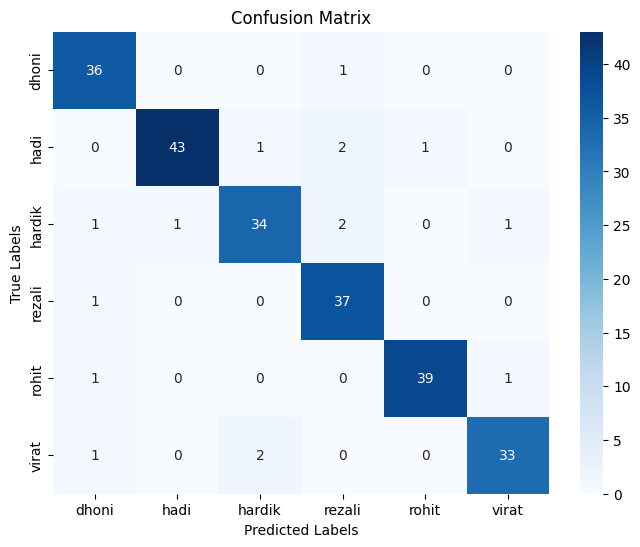

In [ ]:
y_pred_probs = model.predict(X_test)  # Probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back

# ✅ Define Class Names (Extract from Dataset)
class_names = list(label_map.keys())

# ✅ Compute and Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [ ]:
# ✅ Print Classification Report
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


✅ Classification Report:
              precision    recall  f1-score   support

       dhoni       0.90      0.97      0.94        37
        hadi       0.98      0.91      0.95        47
      hardik       0.92      0.87      0.89        39
      rezali       0.88      0.97      0.93        38
       rohit       0.97      0.95      0.96        41
       virat       0.94      0.92      0.93        36

    accuracy                           0.93       238
   macro avg       0.93      0.93      0.93       238
weighted avg       0.93      0.93      0.93       238



### Accuracy & Loss Curves

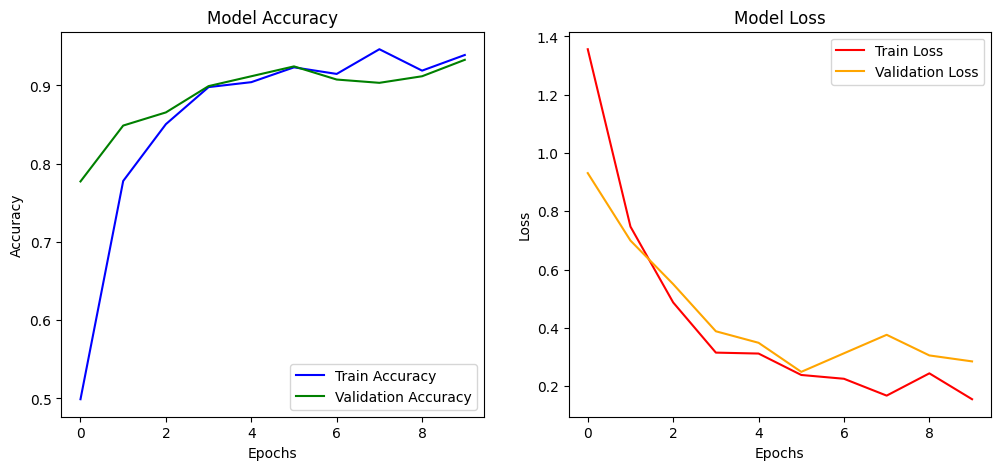

In [ ]:

# ✅  Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# 🔹 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

## 5️⃣ Save the model to avoid training again and again

In [17]:
model.save("face_Recognition.keras")

## 6️⃣ Test Model with Images

In [19]:
# Face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_and_predict(image_path, model, class_names):
    """ Detects a face, preprocesses it, and predicts the person's identity """
    img = cv2.imread(image_path)

    if img is None:
        print("Error: Could not read the image.")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return

    # Crop and preprocess the first detected face
    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (128, 128))  # Resize to match model input
    face_array = img_to_array(face_resized) / 255.0  # Normalize
    face_array = np.expand_dims(face_array, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(face_array)
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]
    confidence = predictions[0][predicted_class] * 100

    print(f"Predicted: {predicted_label} ({confidence:.2f}% confidence)")

    # Show the image with prediction
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, f"{predicted_label} ({confidence:.2f}%)", (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



In [ ]:
test_img_path=r"Face Recognition System\\test_img\\" # Add your own test folder path
for i in os.listdir(test_img_path):
    
    preprocess_and_predict(test_img_path+i, model, class_names)
